# PCA From Scratch

Implementing Principal Component Analysis using only NumPy:
1. Data standardization
2. Covariance matrix computation
3. Eigendecomposition
4. Data transformation
5.Comparison with sklearn

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as SklearnPCA
from sklearn.datasets import load_iris

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)


---
## Load Data: Iris Dataset

4 features, 3 classes - perfect for demonstrating PCA.

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

print(f'Dataset: {X.shape[0]} samples, {X.shape[1]} features')
print(f'Features: {feature_names}')
print(f'Classes: {iris.target_names}')


Dataset: 150 samples, 4 features
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']


---
## Step 1: Standardize the Data

**Critical**: Features must have mean=0 and std=1.

In [3]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_standardized = (X - mean) / std
    return X_standardized, mean, std

X_std, mean, std = standardize(X)

print('Original data:')
print(f'Mean: {np.mean(X, axis=0)}')
print(f'Std: {np.std(X, axis=0)}')
print('\nStandardized data:')
print(f'Mean: {np.mean(X_std, axis=0)}')
print(f'Std: {np.std(X_std, axis=0)}')


Original data:
Mean: [5.84333333 3.05733333 3.758      1.19933333]
Std: [0.82530129 0.43441097 1.75940407 0.75969263]

Standardized data:
Mean: [-1.69031455e-15 -1.84297022e-15 -1.69864123e-15 -1.40924309e-15]
Std: [1. 1. 1. 1.]


---
## Step 2: Compute Covariance Matrix

$$\Sigma = \frac{1}{m}X^TX$$

Covariance matrix shape: (4, 4)

Covariance matrix:
[[ 1.         -0.11756978  0.87175378  0.81794113]
 [-0.11756978  1.         -0.4284401  -0.36612593]
 [ 0.87175378 -0.4284401   1.          0.96286543]
 [ 0.81794113 -0.36612593  0.96286543  1.        ]]


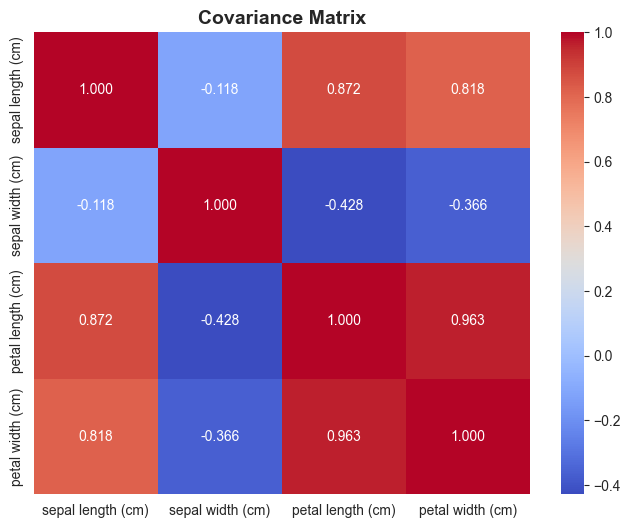

In [4]:
def compute_covariance_matrix(X):
    m = X.shape[0]
    # X already centered (mean=0 after standardization)
    cov_matrix = (1/m) * X.T.dot(X)
    return cov_matrix

cov_matrix = compute_covariance_matrix(X_std)

print('Covariance matrix shape:', cov_matrix.shape)
print('\nCovariance matrix:')
print(cov_matrix)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
           xticklabels=feature_names, yticklabels=feature_names)
plt.title('Covariance Matrix', fontsize=14, fontweight='bold')
plt.show()


---
## Step 3: Compute Eigenvalues and Eigenvectors

In [5]:
def compute_eigen(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort by eigenvalue (descending)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = compute_eigen(cov_matrix)

print('Eigenvalues (variance in each PC):')
print(eigenvalues)
print('\nEigenvectors (principal components):')
print(eigenvectors)


Eigenvalues (variance in each PC):
[2.91849782 0.91403047 0.14675688 0.02071484]

Eigenvectors (principal components):
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


### Variance Explained

PC1: 72.96% (cumulative: 72.96%)
PC2: 22.85% (cumulative: 95.81%)
PC3: 3.67% (cumulative: 99.48%)
PC4: 0.52% (cumulative: 100.00%)


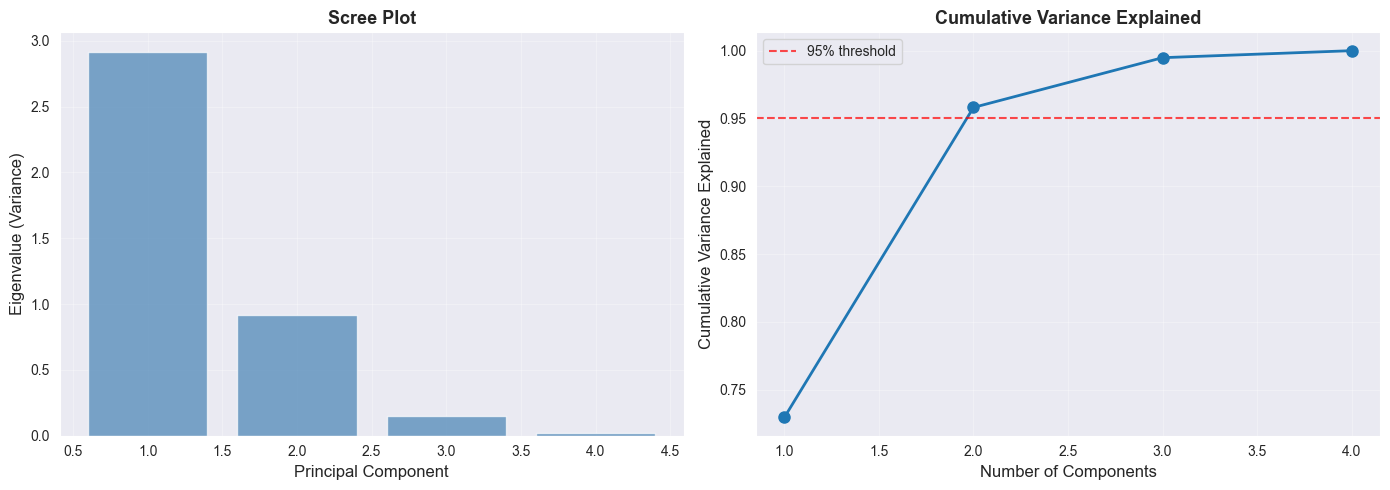

In [6]:
def variance_explained(eigenvalues):
    total_variance = np.sum(eigenvalues)
    var_exp = eigenvalues / total_variance
    cumulative_var_exp = np.cumsum(var_exp)
    return var_exp, cumulative_var_exp

var_exp, cum_var_exp = variance_explained(eigenvalues)

for i in range(len(eigenvalues)):
    print(f'PC{i+1}: {var_exp[i]*100:.2f}% (cumulative: {cum_var_exp[i]*100:.2f}%)')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Eigenvalue (Variance)', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cum_var_exp)+1), cum_var_exp, 'o-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Observation**: First 2 PCs capture ~96% of variance!

---
## Step 4: Transform Data to PC Space

In [7]:
def transform_data(X, eigenvectors, n_components=2):
    # Project onto top n_components
    W = eigenvectors[:, :n_components]
    X_transformed = X.dot(W)
    return X_transformed

# Reduce to 2D
X_pca = transform_data(X_std, eigenvectors, n_components=2)

print(f'Original shape: {X_std.shape}')
print(f'Transformed shape: {X_pca.shape}')


Original shape: (150, 4)
Transformed shape: (150, 2)


### Visualize in 2D PC Space

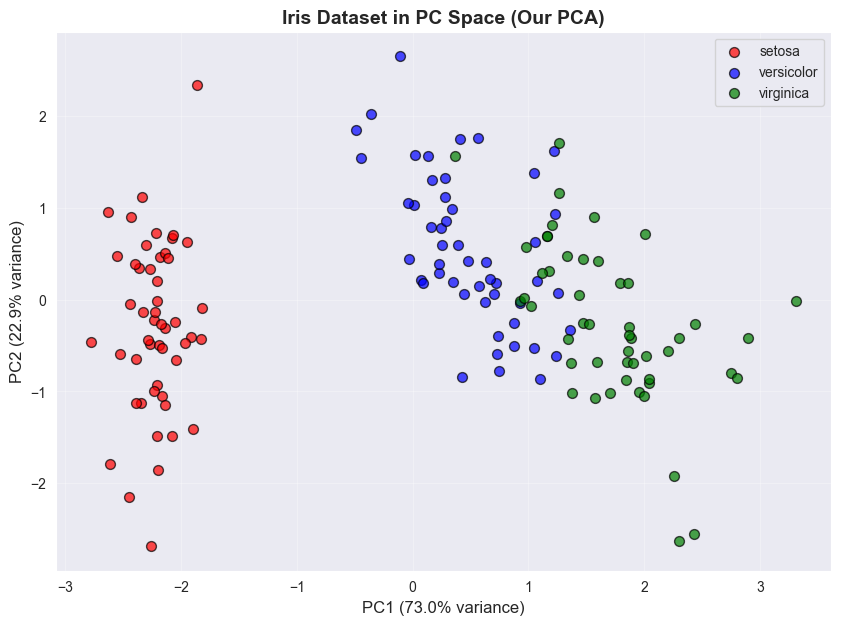

In [8]:
plt.figure(figsize=(10, 7))
colors = ['red', 'blue', 'green']
for i, color in enumerate(colors):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=color, label=iris.target_names[i], 
               alpha=0.7, edgecolors='k', s=50)

plt.xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance)', fontsize=12)
plt.title('Iris Dataset in PC Space (Our PCA)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---
## Complete PCA Function

In [9]:
def pca_from_scratch(X, n_components=2):
    """
    PCA implementation from scratch.
    
    Steps:
    1. Standardize
    2. Covariance matrix
    3. Eigendecomposition
    4. Sort and select top k
    5. Transform
    """
    # Standardize
    X_std, mean, std = standardize(X)
    
    # Covariance
    cov_matrix = compute_covariance_matrix(X_std)
    
    # Eigen
    eigenvalues, eigenvectors = compute_eigen(cov_matrix)
    
    # Transform
    X_transformed = transform_data(X_std, eigenvectors, n_components)
    
    return X_transformed, eigenvalues, eigenvectors, mean, std

# Use it
X_pca, eigenvals, eigenvecs, _, _ = pca_from_scratch(X, n_components=2)
print(f'Transformed data shape: {X_pca.shape}')


Transformed data shape: (150, 2)


---
## Compare with Scikit-Learn

COMPARISON: OUR vs SKLEARN
Our explained variance:      [2.91849782 0.91403047]
sklearn explained variance:  [4.22824171 0.24267075]

Our variance ratio:          [0.72962445 0.22850762]
sklearn variance ratio:      [0.92461872 0.05306648]


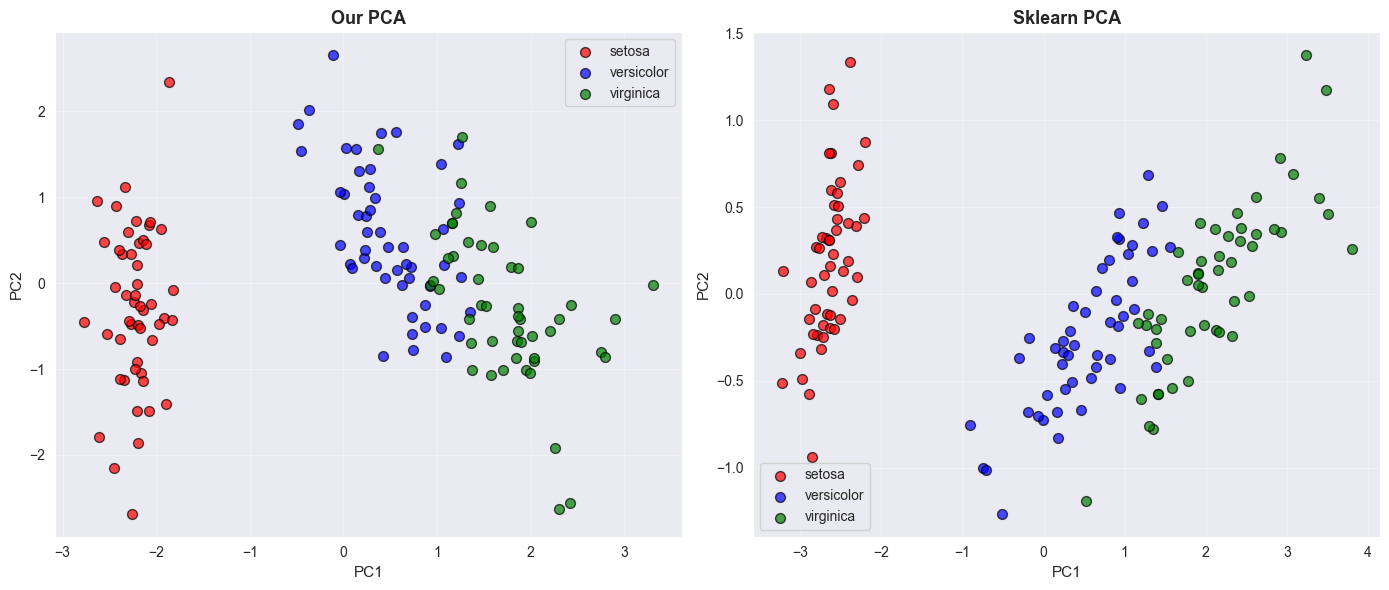


Note: Directions may be flipped (eigenvectors have arbitrary sign) but patterns are identical!


In [10]:
# Our PCA
our_pca, our_eigenvals, our_eigenvecs, _, _ = pca_from_scratch(X, n_components=2)

# sklearn PCA
sklearn_pca = SklearnPCA(n_components=2)
sklearn_transformed = sklearn_pca.fit_transform(X)

print('='*60)
print('COMPARISON: OUR vs SKLEARN')
print('='*60)
print(f'Our explained variance:      {our_eigenvals[:2]}')
print(f'sklearn explained variance:  {sklearn_pca.explained_variance_}')
print(f'\nOur variance ratio:          {our_eigenvals[:2] / np.sum(our_eigenvals)}')
print(f'sklearn variance ratio:      {sklearn_pca.explained_variance_ratio_}')

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, color in enumerate(colors):
    mask = y == i
    axes[0].scatter(our_pca[mask, 0], our_pca[mask, 1], 
                   c=color, label=iris.target_names[i], alpha=0.7, edgecolors='k', s=50)
    axes[1].scatter(sklearn_transformed[mask, 0], sklearn_transformed[mask, 1],
                   c=color, label=iris.target_names[i], alpha=0.7, edgecolors='k', s=50)

axes[0].set_title('Our PCA', fontsize=13, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Sklearn PCA', fontsize=13, fontweight='bold')
axes[1].set_xlabel('PC1', fontsize=11)
axes[1].set_ylabel('PC2', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nNote: Directions may be flipped (eigenvectors have arbitrary sign) but patterns are identical!')


---
## Summary

### PCA Algorithm:
1. **Standardize** data (mean=0, std=1)
2. **Compute covariance** matrix: $\Sigma = \frac{1}{m}X^TX$
3. **Eigendecomposition**: Find eigenvalues and eigenvectors of $\Sigma$
4. **Sort** by eigenvalue (descending)
5. **Select** top k eigenvectors
6. **Transform**: $X_{PCA} = X \cdot W_k$

### What We get:
- **Eigenvectors**: New axes (principal components)
- **Eigenvalues**: Variance along each PC
- **Transformed data**: Lower dimensional representation

### Key Insights:
- PC1 captures most variance
- PCs are orthogonal (independent)
- Can choose k to retain desired variance (e.g., 95%)
- Standardization is CRITICAL!

**Interview Tip**: "PCA finds orthogonal directions of maximum variance by eigendecomposing the covariance matrix. The eigenvectors are the principal components, eigenvalues tell us variance explained. After standardizing, we compute the covariance matrix, find eigenvectors, and project data onto the top k components."